In [ ]:
import collections.abc
collections.Iterable = collections.abc.Iterable
collections.Mapping = collections.abc.Mapping
collections.MutableSet = collections.abc.MutableSet
collections.MutableMapping = collections.abc.MutableMapping

import matplotlib as mpl
import matplotlib.animation
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib ipympl

plt.rcParams['figure.figsize'] = [10, 4]
plt.rcParams['font.size'] = 8
mpl.rc('image', cmap='gray')
import trackpy as tp
tp.quiet()

import numpy as np
import pandas as pd
import csv, json
import pims
from PIL import Image, ImageDraw
import cv2

from scipy.optimize import dual_annealing, linear_sum_assignment
from scipy.spatial import distance_matrix
from tqdm import tqdm
import random

import skimage
from csbdeep.utils import normalize
from stardist.models import StarDist2D
from stardist.data import test_image_nuclei_2d
from stardist.plot import render_label
from csbdeep.utils import normalize
from stardist import random_label_cmap, _draw_polygons, export_imagej_rois
np.random.seed(6)
lbl_cmap = random_label_cmap()
# initialize model with versatile fluorescence pretrained weights
model = StarDist2D.from_pretrained('2D_versatile_fluo')
print(model)

In [ ]:
@pims.pipeline
def preprocessing(image, x1, y1, x2, y2):
    """
    Preprocessing function for the data.

    Parameters
    ----------
    image : pims.Frame
        Frame of the video.
    x1 : int
        x coordinate of the top left corner of the ROI. (region of interest)
    y1 : int
        y coordinate of the top left corner of the ROI.
    x2 : int    
        x coordinate of the bottom right corner of the ROI.
    y2 : int    
        y coordinate of the bottom right corner of the ROI.

    Returns
    -------
    npImage : np.array
        Preprocessed image.
    """
    npImage = np.array(image)
    alpha = Image.new('L', (920, 960), 0)
    draw = ImageDraw.Draw(alpha)
    draw.pieslice(((x1, y1), (x2, y2)), 0, 360, fill=255)
    npAlpha = np.array(alpha)
    npImage = cv2.cvtColor(npImage, cv2.COLOR_BGR2GRAY)*npAlpha
    ind = np.where(npImage == 0)
    npImage[ind] = npImage[200, 200]
    kernel = np.array([[0, -1, 0],
                   [-1, 5,-1],
                   [0, -1, 0]])
    # sharpen image https://en.wikipedia.org/wiki/Kernel_(image_processing)
    image_sharp = cv2.filter2D(src=npImage, ddepth=-1, kernel=kernel)
    #npImage = cv2.medianBlur(npImage, 5)
    #npImage = normalize(npImage)
    return npImage

In [ ]:
data = preprocessing(pims.open('./data/movie.mp4'), 40, 55, 895, 910)
fig, ax = plt.subplots(1, 1, figsize=(10, 4))
ax.imshow(data[0], cmap='gray')
plt.show()

In [4]:
if 0:
    preprocessed_data = np.zeros((30000, data[0].shape[0], data[0].shape[1]), dtype=data[0].dtype)
    for i in tqdm(range(30000)):
        preprocessed_data[i] = data[i]
    #np.savez_compressed('./data/preprocessed_data.npz', data=preprocessed_data) # --> 15 min
else:
    preprocessed_data = np.load('./data/preprocessed_data_noblur.npz')['data'] # --> 3 min

In [15]:
path ='./stardist_res/noblur/'

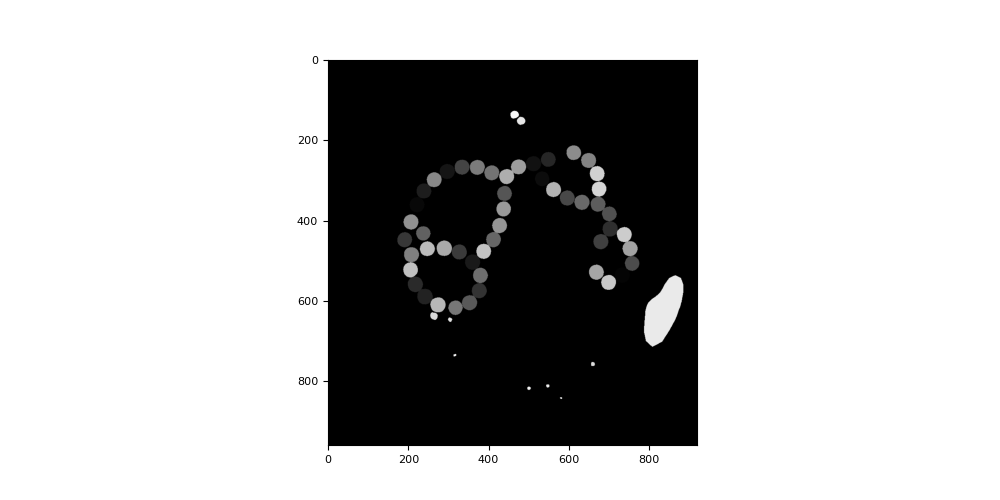

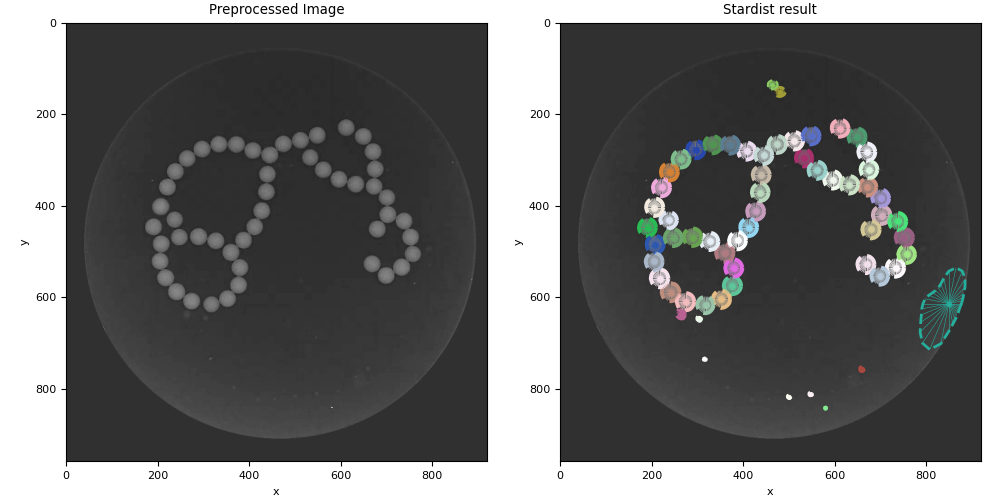

In [6]:
## TEST
frame = -1
img = preprocessed_data[frame]
labels_test, dict_test = model.predict_instances(normalize(img), predict_kwargs = {'verbose':False}) 

fig, ax = plt.subplots(1, 1, figsize = (10, 5))
ax.imshow(labels_test)
plt.show()

plt.figure(figsize = (10, 5))
coord, points, prob = dict_test['coord'], dict_test['points'], dict_test['prob']
ax = plt.subplot(121)
ax.imshow(img, cmap='gray'); #plt.axis('off')
ax.set(title = 'Preprocessed Image', xlabel='x', ylabel='y')
ax1 = plt.subplot(122, sharex=ax, sharey=ax)
ax1.imshow(img, cmap='gray'); #plt.axis('off')
_draw_polygons(coord, points, prob, show_dist=True)
ax1.set(title = 'Stardist result', xlabel='x', ylabel='y')
#ax.set(xlim=(200, 600), ylim=(200, 600))
plt.tight_layout()
plt.savefig(path + 'stardist_test.png', bbox_inches='tight')
plt.show()

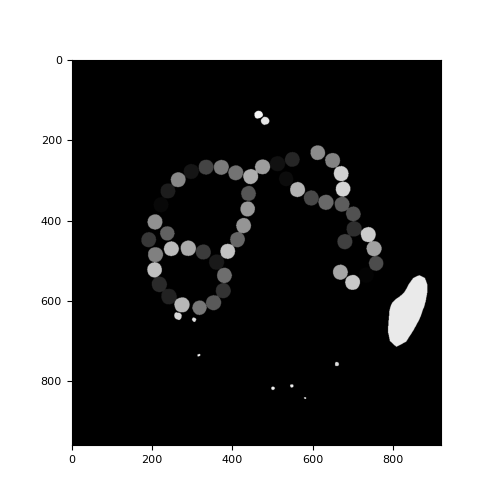

In [12]:
run = False
if run:
    ## SEGMENT ALL FRAMES AND SAVE THEM IN A NPZ FILE 
    ## COMPUTE THE FEATURES AND SAVE THEM IN A DATAFRAME
    nFrames = 10000
    segm_preload = np.zeros((nFrames, 960, 920), dtype=np.int8)
    area, x, y, prob = [], [], [], []

    for frame in tqdm(range(nFrames)):
        segm_preload[frame], dict_test = model.predict_instances(normalize(data[frame]), predict_kwargs = {'verbose':False})
        test = skimage.measure.regionprops_table(segm_preload[frame], properties=('centroid', 'area'))
        area += list(test['area'])
        x += list(test['centroid-0'])
        y += list(test['centroid-1'])
        prob += list(dict_test['prob'])
        frames += list(np.ones(len(test))*frame)

    df = pd.DataFrame({'x':x, 'y':y, 'area':area, 'prob':prob})
    df.to_parquet('./data/df.parquet')
    print(df)

    # Save the labeled elements using numpy.savez_compressed
    np.savez_compressed(path, data=segm_preload)
else:
    #labeled_elements = np.load(path + 'segm.npz')['labelled_elements'] #'data'
    fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    ax.imshow(labeled_elements[-1], cmap='gray')
    plt.show()

In [13]:
labeled_elements.shape

(30000, 960, 920)

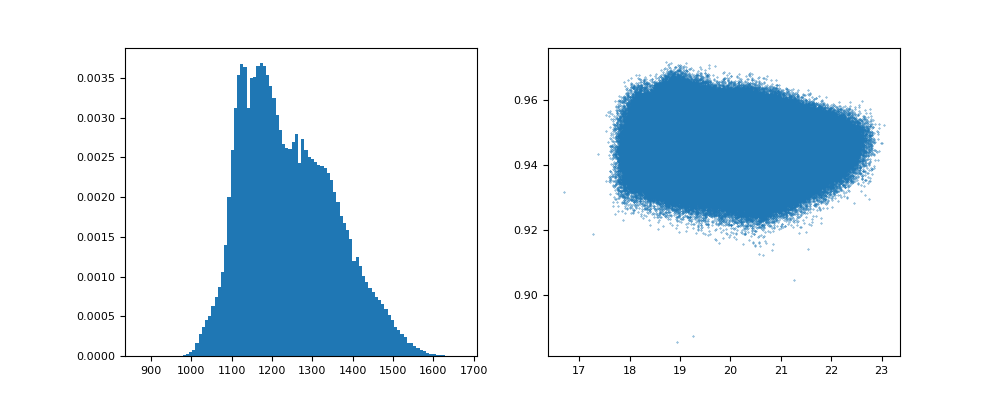

In [16]:
df = pd.read_parquet(path + 'df.parquet')
df['frame'] = df.frame.astype('int')
df['r'] = np.sqrt(df.area/np.pi)
df = df.loc[df.r.between(10, 30)]
df.sort_values(by=['frame', 'prob'], ascending=False, inplace=True)

# select top 50 features with highest probability
num_top_rows = 50  
indices = np.concatenate([np.arange(start, start + num_top_rows) for start in np.unique(df['frame'], return_index=True)[1]])
df = df.iloc[indices].reset_index(drop=True)

fig, (ax, ax1) = plt.subplots(1, 2, figsize=(10, 4))
ax.hist(df.area, bins=100, density=True)
ax1.scatter(df.r, df.prob, s=0.1)
plt.show()

In [ ]:
frame_example = df.loc[df.r<12].frame.values[0]
fig, (ax, ax1) = plt.subplots(1, 2, figsize=(10, 4))
ax.imshow(preprocessed_data[frame_example], cmap='gray')
ax.set(xlabel='x', ylabel='y', title='Preprocessed Image')
ax1.imshow(labeled_elements[frame_example], cmap='gray')
ax1.set(xlabel='x', ylabel='y', title='Masked Image')
plt.show()

In [18]:
#############################################################################################################
#                                         LINK FEATURES WITH TRACKPY                                        #
#############################################################################################################
if 0:
    t = tp.link_df(df, 150, memory = 0, link_strategy = 'hybrid', neighbor_strategy = 'KDTree', adaptive_stop = 1)
    print(t)
    t = t.sort_values(['frame', 'particle'])

    # CREATE COLOR COLUMN AND SAVE DF
    n = max(t.particle)
    print(n)
    random.seed(5)
    colors = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)]) for i in range(n)]
    for i in range(max(t.particle)+1-n):
        colors.append("#00FFFF")
    c = []
    for p in t.particle:
        c.append(colors[p])
    t["color"] = c
    trajectory = t.copy()
    print(trajectory)
    trajectory.to_parquet(path + 'df_linked.parquet')
else:
    trajectory = pd.read_parquet(path + 'df_linked.parquet')
    print(trajectory)

                  x           y  area      prob  frame          r  particle   
0        312.086240  289.999366  1577  0.955325      0  22.404792         0  \
27       294.914087  703.343020  1583  0.946784      0  22.447373         1   
28       777.200377  498.037060  1592  0.946181      0  22.511094         2   
29       303.219097  209.706344  1529  0.945984      0  22.061183         3   
30       589.951923  513.216667  1560  0.945804      0  22.283703         4   
...             ...         ...   ...       ...    ...        ...       ...   
1499991  322.609489  561.818431  1096  0.943081  29999  18.677999        45   
1499962  447.646140  190.720588  1088  0.954753  29999  18.609706        46   
1499980  249.957273  649.240000  1100  0.947018  29999  18.712052        47   
1499986  266.042611  474.504986  1103  0.944697  29999  18.737551        48   
1499989  468.944062  289.358864  1162  0.943968  29999  19.232163        49   

           color  
0        #8B0E71  
27       #53B

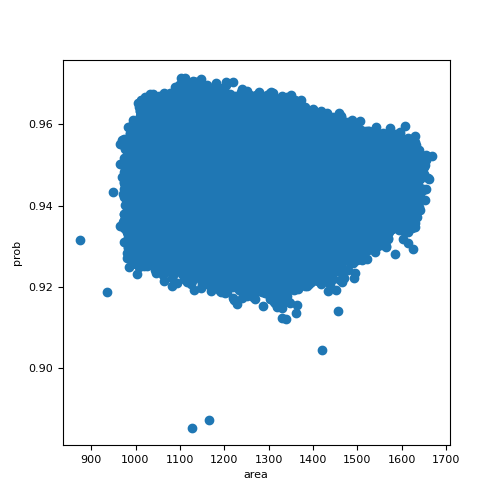

deprecated pixel format used, make sure you did set range correctly
 (repeated 25 more times)
deprecated pixel format used, make sure you did set range correctly
deprecated pixel format used, make sure you did set range correctly
deprecated pixel format used, make sure you did set range correctly
deprecated pixel format used, make sure you did set range correctly


KeyboardInterrupt: 

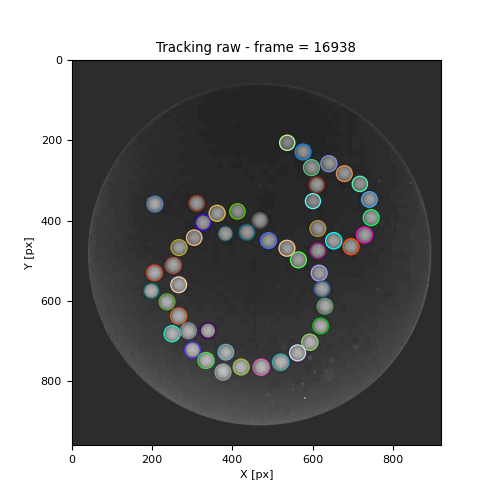

In [20]:
fig = plt.figure(figsize = (5, 5))
anim_running = True

def onClick(event):
    global anim_running
    if anim_running:
        ani.event_source.stop()
        anim_running = False
    else:
        ani.event_source.start()
        anim_running = True

def update_graph(frame):
    df = trajectory.loc[(trajectory.frame == frame) , ["x","y","color","r"]]
    for i in range(50):
        graph[i].center = (df.y.values[i], df.x.values[i])
        graph[i].radius = df.r.values[i]
    graph2.set_data(data[frame])
    title.set_text('Tracking raw - frame = {}'.format(frame))
    return graph

ax = fig.add_subplot(111)
title = ax.set_title('Tracking stardist + trackpy - frame = 0')
ax.set(xlabel = 'X [px]', ylabel = 'Y [px]')
df = trajectory.loc[(trajectory.frame == 0), ["x","y","color","r"]]

graph = []
for i in range(50):
    graph.append(ax.add_artist(plt.Circle((df.y.values[i], df.x.values[i]), df.r.values[i], color = df.color.values[i],\
                                           fill = False, linewidth=1)))
graph2 = ax.imshow(data[0])

fig.canvas.mpl_connect('button_press_event', onClick)
ani = matplotlib.animation.FuncAnimation(fig, update_graph, range(0, max(trajectory.frame), 1), interval = 5, blit=False)
if 1: 
    writer = matplotlib.animation.FFMpegWriter(fps = 30, metadata = dict(artist='Matteo Scandola'), extra_args=['-vcodec', 'libx264'])
    ani.save(path + 'tracking.mp4', writer=writer, dpi = 300)
plt.close()

In [ ]:
area, x, y, prob = [], [], [], []
for frame in tqdm(range(20)):
    labels_test, dict_test = model.predict_instances(data_preload[frame], prob_thresh=0.9, predict_kwargs = {'verbose':False})
    test = skimage.measure.regionprops_table(labels_test, properties=('centroid', 'area'))
    area += list(test['area'])
    x += list(test['centroid-0'])
    y += list(test['centroid-1'])
    prob += list(dict_test['prob'])

df = pd.DataFrame({'x':x, 'y':y, 'area':area, 'prob':prob})
#display(df)
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.hist(df['area'], bins=200, density=True)
ax.set(xlabel='area', ylabel='count')
plt.show()

In [ ]:
loaded_data = np.load(path)
labeled_elements = loaded_data['labeled_elements']

In [ ]:
np.where(labeled_elements-segm_preload !=0)

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.imshow(labeled_elements[0], cmap='gray')
plt.show()